# LOADING DATA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/APPLE DISESASE DATASET'

In [3]:


import os

print(os.listdir(data_dir))

['cedar_apple_rust', 'healthy', 'apple_scab', 'black_rot']


# CHECKING CLASS IMBALANCE

In [4]:
folder_names = []
image_counts = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        image_count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        folder_names.append(folder)
        image_counts.append(image_count)

In [5]:
for name, count in zip(folder_names, image_counts):
    print(f" {name}:  {count} images")

 cedar_apple_rust:  2200 images
 healthy:  2510 images
 apple_scab:  2520 images
 black_rot:  2484 images


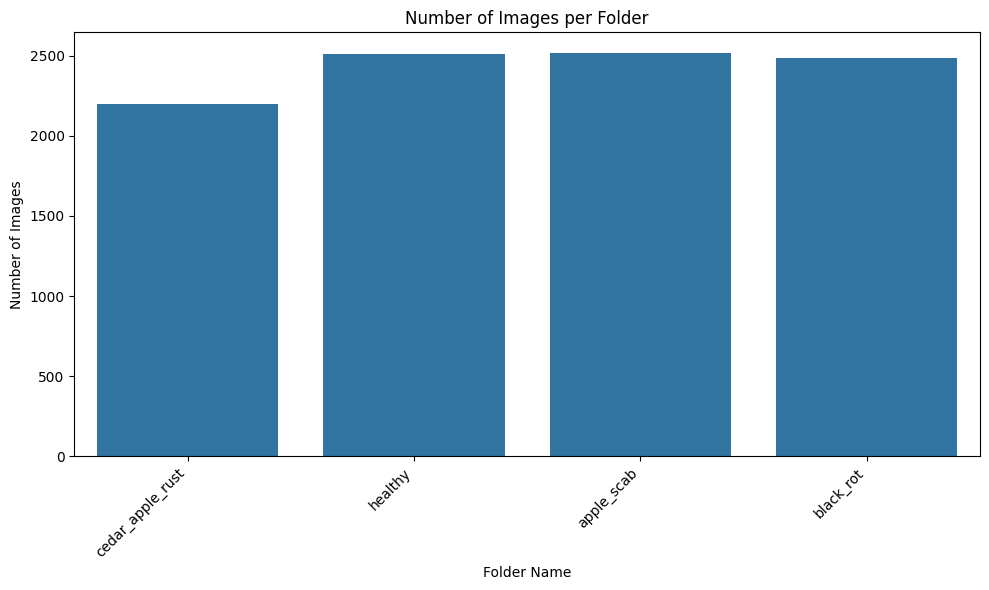

In [6]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=folder_names, y=image_counts)
plt.xlabel("Folder Name")
plt.ylabel("Number of Images")
plt.title("Number of Images per Folder")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# FEATURE EXTRACTION


**IMPORT REQUIERED LIBRARIES**

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder

**DEFINING PARAMETERS**

In [8]:
image_size = 224  # EfficientNetB0 input size
batch_size = 32

**Define Augmentation**

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

**CHECK AUGMENTATION**



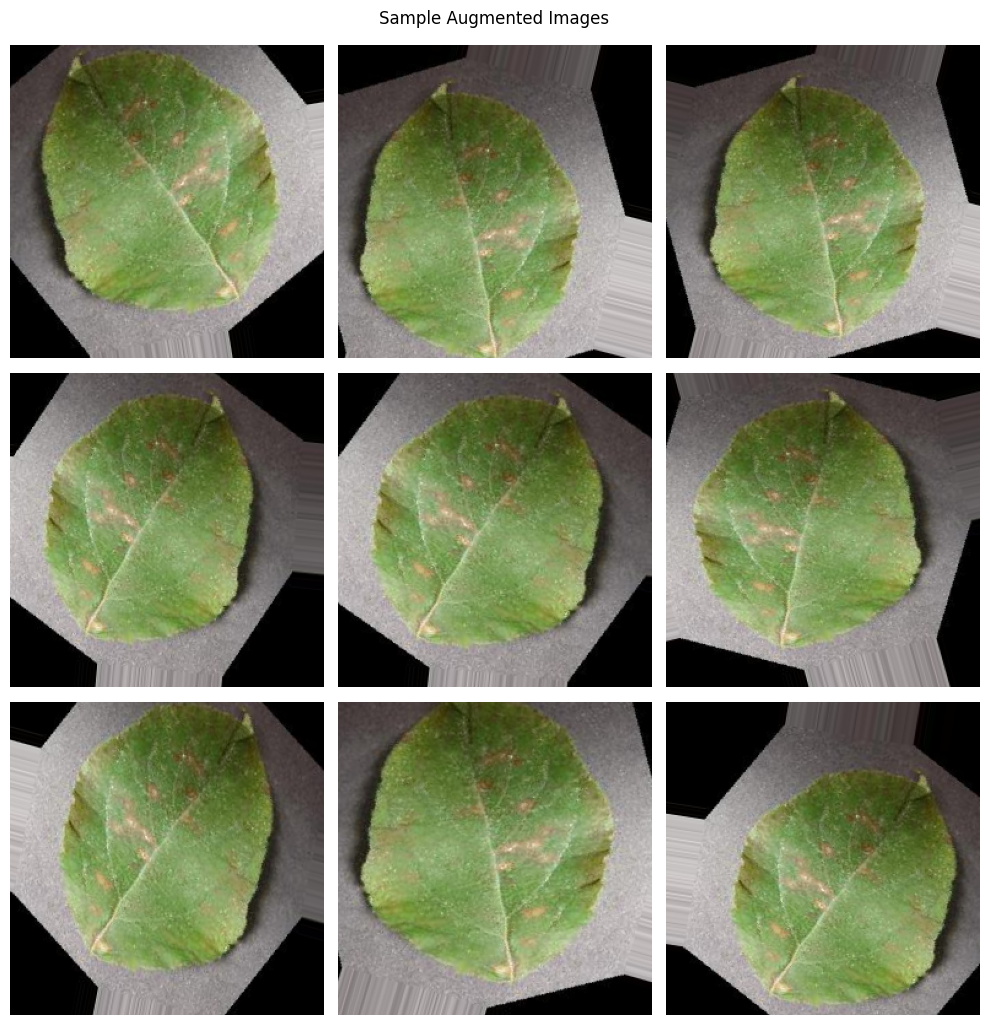

In [10]:

# Display a sample of augmented images
sample_image_path = os.path.join(data_dir, folder_names[0], os.listdir(os.path.join(data_dir, folder_names[0]))[0])
sample_image = plt.imread(sample_image_path)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Reshape image to (1, height, width, channels) for datagen
    augmented_image = datagen.random_transform(sample_image)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample Augmented Images', y=1.02)
plt.show()

**defining data generator**

In [11]:
# Create data generator
generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 9714 images belonging to 4 classes.


# **Load EfficientNetB0 Model**

In [12]:
# Load EfficientNetB0 for feature extraction
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**FEATURE EXTRACTION**

In [13]:
from tqdm import tqdm
import numpy as np

features = []
labels = []

num_batches = int(np.ceil(generator.samples / batch_size))
print("Starting feature extraction...")

for _ in tqdm(range(num_batches), desc="Extracting Features"):
    x_batch, y_batch = next(generator)  # Pythonic way
    batch_features = model.predict(x_batch, verbose=0)
    features.append(batch_features)
    labels.append(y_batch)

features = np.vstack(features)
labels = np.concatenate(labels)

print(f" Feature extraction complete. Features shape: {features.shape}, Labels shape: {labels.shape}")


Starting feature extraction...


Extracting Features: 100%|██████████| 304/304 [47:59<00:00,  9.47s/it]

 Feature extraction complete. Features shape: (9714, 1280), Labels shape: (9714,)


In [14]:

# Convert numerical labels to original class names
label_map = {v: k for k, v in generator.class_indices.items()}
original_labels = [label_map[label] for label in labels]

# Display a few samples with labels and feature vectors
print("\nSample data points:")
for i in range(5): # Display first 5 samples
    print(f"  Sample {i+1}:")
    print(f"    Label: {original_labels[i]}")
    print(f"    Feature Vector (first 10 elements): {features[i][:10]}...")
    print("-" * 20)


Sample data points:
  Sample 1:
    Label: apple_scab
    Feature Vector (first 10 elements): [ 0.13768202 -0.19124034 -0.04548021 -0.08847573 -0.14678353 -0.11123867
 -0.04661426 -0.10799808 -0.09151055 -0.02982522]...
--------------------
  Sample 2:
    Label: apple_scab
    Feature Vector (first 10 elements): [-0.11673516 -0.16746293 -0.12954816 -0.12010302 -0.12154857 -0.1489212
 -0.07513832 -0.1471482  -0.14826708 -0.18816897]...
--------------------
  Sample 3:
    Label: apple_scab
    Feature Vector (first 10 elements): [ 0.23221922 -0.15120274 -0.0332907  -0.07117544 -0.14284955 -0.1078877
  0.04904189 -0.15332597 -0.11452433 -0.19028498]...
--------------------
  Sample 4:
    Label: apple_scab
    Feature Vector (first 10 elements): [-0.10903909 -0.1334527  -0.13431747 -0.1686397  -0.18052922 -0.10639906
  0.08419454 -0.17153646 -0.09155303 -0.17960466]...
--------------------
  Sample 5:
    Label: apple_scab
    Feature Vector (first 10 elements): [ 0.40451017 -0.1853932

**encoding classes**

In [17]:
le= LabelEncoder()
encoded_labels = le.fit_transform(labels)



**saving to disk**

In [16]:
# Save to disk
np.save('/content/drive/MyDrive/ML_apple_features.npy', features)
np.save('/content/drive/MyDrive/ML_apple_labels.npy', encoded_labels)
np.save('/content/drive/MyDrive/ML-apple_label_classes.npy', le.classes_)

print("Feature shape:", features.shape)
print("Labels shape:", encoded_labels.shape)
print("Label classes:", le.classes_)


Feature shape: (9714, 1280)
Labels shape: (9714,)
Label classes: [0. 1. 2. 3.]


In [18]:
# vector size of image

print(f"The size of the image vector is: {features.shape[1]}")

The size of the image vector is: 1280


# **loding features**

In [22]:

# Load the saved data
loaded_features = np.load('/content/drive/MyDrive/ML_apple_features.npy')
loaded_encoded_labels = np.load('/content/drive/MyDrive/ML_apple_labels.npy')
loaded_label_classes = np.load('/content/drive/MyDrive/ML-apple_label_classes.npy', allow_pickle=True)

print("Loaded features shape:", loaded_features.shape)
print("Loaded labels shape:", loaded_encoded_labels.shape)
print("Loaded label classes:", loaded_label_classes)



Loaded features shape: (9714, 1280)
Loaded labels shape: [0 0 0 ... 3 3 3]
Loaded label classes: [0. 1. 2. 3.]


**shuffling to get better result**

In [21]:

from sklearn.utils import shuffle


# Shuffle the features and labels together
shuffled_features, shuffled_labels = shuffle(loaded_features, loaded_encoded_labels, random_state=42) # Use a random_state for reproducibility

print("Shuffled features shape:", shuffled_features.shape)
print("Shuffled labels shape:", shuffled_labels.shape)



Shuffled features shape: (9714, 1280)
Shuffled labels shape: (9714,)


**MODELS**

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier



**SPLITTING**

In [24]:
# Split the shuffled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.2, random_state=42, stratify=shuffled_labels)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (7771, 1280)
Testing features shape: (1943, 1280)
Training labels shape: (7771,)
Testing labels shape: (1943,)


**FEATURE SCALING**

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**DEAFAULT MODELS TRAINING**

In [30]:
# Define a dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(),  # max_iter=100 default
    "Support Vector Machine": SVC(),               # default kernel='rbf'
    "Decision Tree": DecisionTreeClassifier(),     # no max_depth
    "Random Forest": RandomForestClassifier(),     # 100 trees
    "XGBClassifier": XGBClassifier(use_label_encoder=True),  # old default (deprecated)
    "K-Nearest Neighbors": KNeighborsClassifier(), # weights='uniform'
    "Gaussian Naive Bayes": GaussianNB(),
}

In [31]:
# Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=loaded_label_classes, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm
    }


--- Training Logistic Regression ---

--- Training Support Vector Machine ---

--- Training Decision Tree ---

--- Training Random Forest ---

--- Training XGBClassifier ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:21:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Training K-Nearest Neighbors ---

--- Training Gaussian Naive Bayes ---


In [35]:


for model_name, result in results.items():
    print(f"{model_name} Accuracy: {result['accuracy']:.4f}")

Logistic Regression Accuracy: 0.9954
Support Vector Machine Accuracy: 0.9928
Decision Tree Accuracy: 0.7952
Random Forest Accuracy: 0.9578
XGBClassifier Accuracy: 0.9763
K-Nearest Neighbors Accuracy: 0.9578
Gaussian Naive Bayes Accuracy: 0.8806


<ipython-input-38-ce4da74cfa64>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


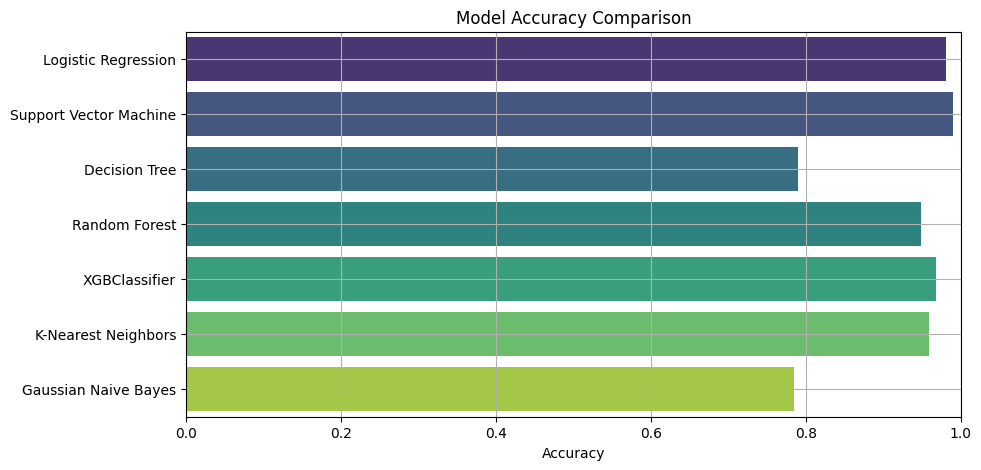

In [38]:
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]

plt.figure(figsize=(10, 5))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)
plt.grid(True)
plt.show()


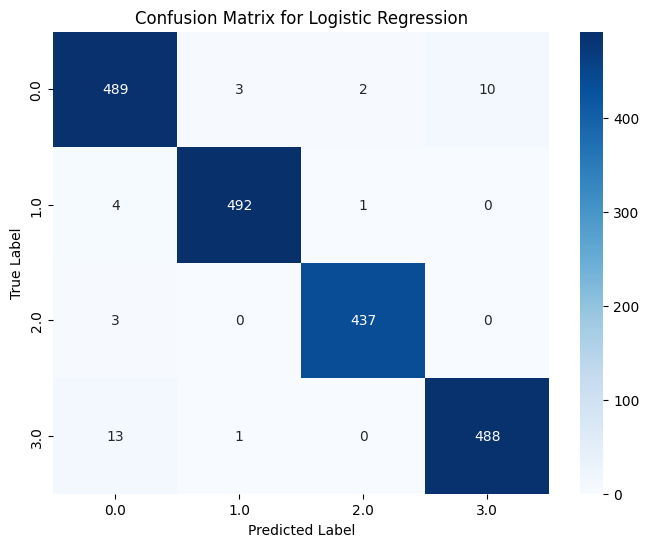

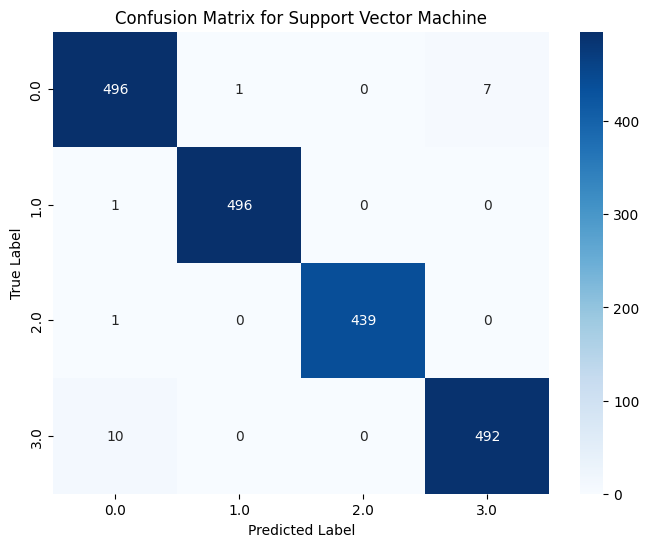

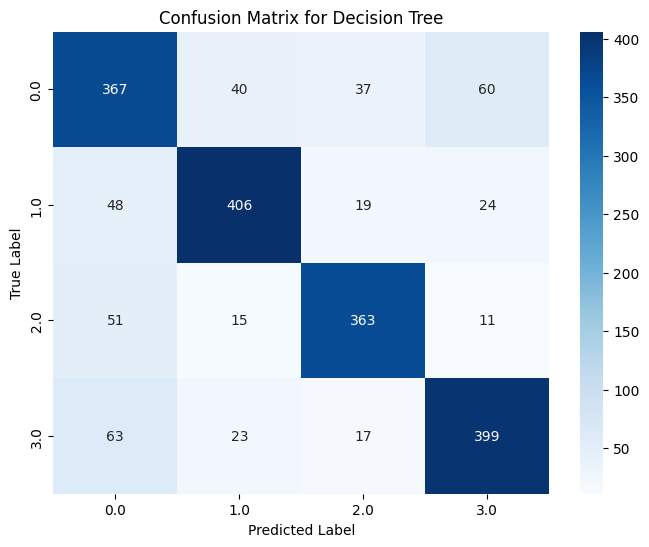

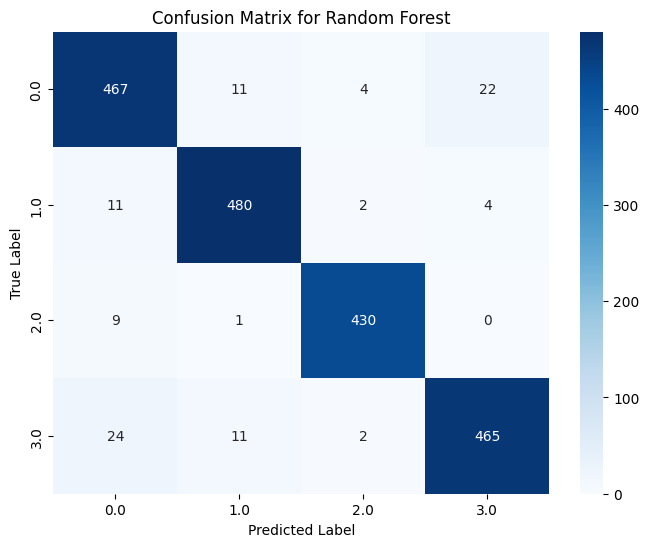

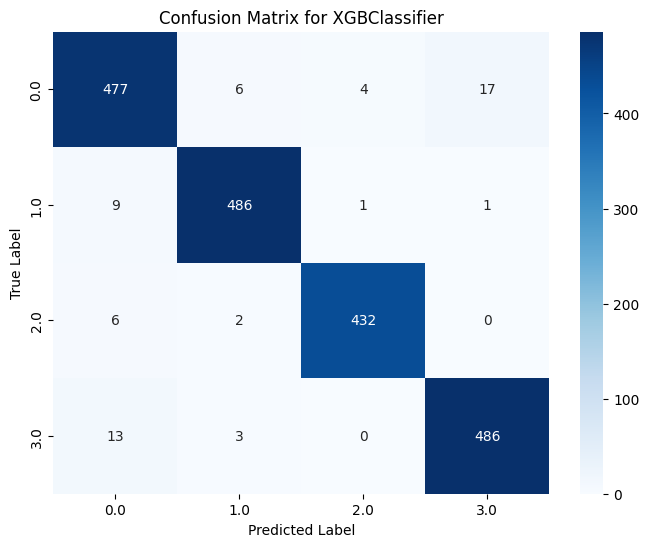

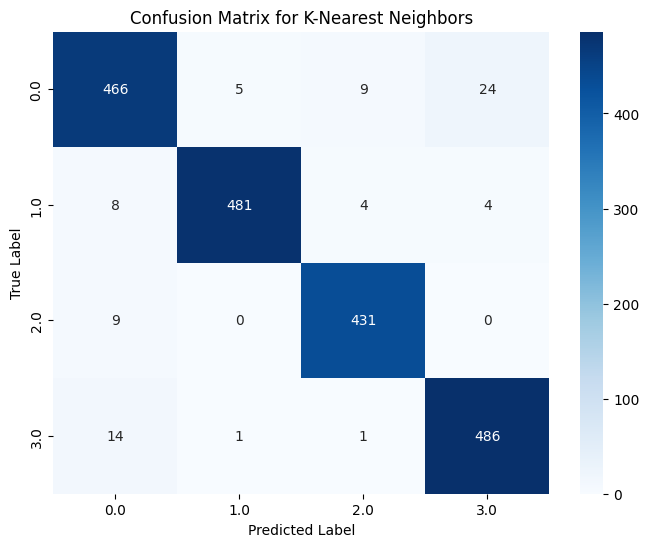

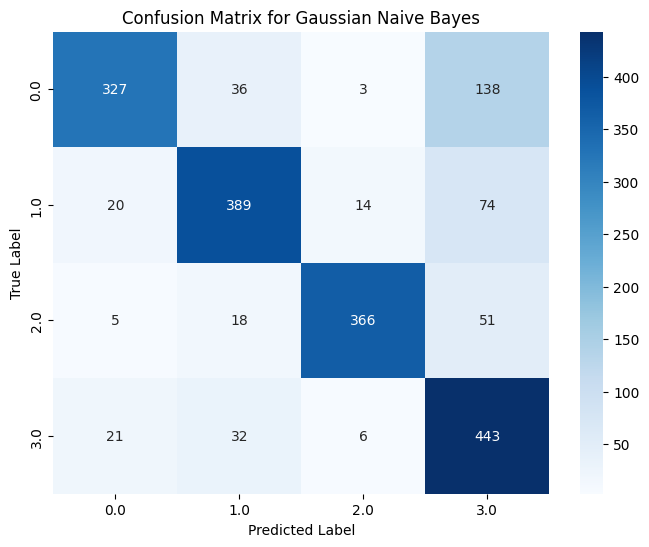

In [43]:


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Display Confusion Matrices for all models
for model_name, result in results.items():
    cm = result['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_label_classes, yticklabels=loaded_label_classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [40]:


# CHECK OVERFITTING/UNDERFITTING
# A simple way to check for overfitting/underfitting is to compare training accuracy with testing accuracy.

print("\n--- Checking for Overfitting/Underfitting ---")

for model_name, model in models.items():
    # Get training predictions
    y_train_pred = model.predict(X_train)
    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Get testing accuracy from results dictionary
    test_accuracy = results[model_name]["accuracy"]

    print(f"\n{model_name}:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Testing Accuracy:  {test_accuracy:.4f}")

    # Simple check for overfitting/underfitting based on a heuristic
    # These thresholds are just indicative and may need tuning
    difference = train_accuracy - test_accuracy
    if difference > 0.1: # If training accuracy is significantly higher than test accuracy
        print("  Potential Overfitting")
    elif train_accuracy < 0.6 and test_accuracy < 0.6: # If both are low
        print("  Potential Underfitting")
    elif abs(difference) < 0.05 and train_accuracy > 0.8: # If accuracies are close and high
        print("  Good Fit")
    else:
        print("  Acceptable Fit or requires further investigation")




--- Checking for Overfitting/Underfitting ---

Logistic Regression:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9810
  Good Fit

Support Vector Machine:
  Training Accuracy: 0.9997
  Testing Accuracy:  0.9897
  Good Fit

Decision Tree:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.7900
  Potential Overfitting

Random Forest:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9480
  Acceptable Fit or requires further investigation

XGBClassifier:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9681
  Good Fit

K-Nearest Neighbors:
  Training Accuracy: 0.9770
  Testing Accuracy:  0.9593
  Good Fit

Gaussian Naive Bayes:
  Training Accuracy: 0.8916
  Testing Accuracy:  0.7849
  Potential Overfitting


In [42]:

# Create a directory to save the models
model_save_dir = '/content/drive/MyDrive/ml_project'
os.makedirs(model_save_dir, exist_ok=True)

# Save each trained model
import pickle

for model_name, model in models.items():
    # Create a valid filename
    filename = os.path.join(model_save_dir, f'{model_name.replace(" ", "_").lower()}_model.pkl')
    print(f"Saving {model_name} model to {filename}...")
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

print("\nAll trained models saved successfully.")


Saving Logistic Regression model to /content/drive/MyDrive/ml_project/logistic_regression_model.pkl...
Saving Support Vector Machine model to /content/drive/MyDrive/ml_project/support_vector_machine_model.pkl...
Saving Decision Tree model to /content/drive/MyDrive/ml_project/decision_tree_model.pkl...
Saving Random Forest model to /content/drive/MyDrive/ml_project/random_forest_model.pkl...
Saving XGBClassifier model to /content/drive/MyDrive/ml_project/xgbclassifier_model.pkl...
Saving K-Nearest Neighbors model to /content/drive/MyDrive/ml_project/k-nearest_neighbors_model.pkl...
Saving Gaussian Naive Bayes model to /content/drive/MyDrive/ml_project/gaussian_naive_bayes_model.pkl...

All trained models saved successfully.


**DIMENSION REDUCTION and again trainig with custom parameters**

In [33]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

In [34]:
# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# SelectKBest
kbest = SelectKBest(score_func=f_classif, k=100)  # adjust k as needed
X_train_reduced = kbest.fit_transform(X_train_pca, y_train)
X_test_reduced = kbest.transform(X_test_pca)

print("Reduced feature shape:", X_train_reduced.shape)


Reduced feature shape: (7771, 100)


In [36]:
# Recommended tuned models
recommended_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),  # can tune later
    "Decision Tree": DecisionTreeClassifier(max_depth=20),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "K-Nearest Neighbors": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',  # weight neighbors by distance
        p=2
    ),
    "Gaussian Naive Bayes": GaussianNB(),
}

In [37]:

results = {}

for name, model in recommended_models.items():
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "report": report
    }

    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.9810
Support Vector Machine Accuracy: 0.9897
Decision Tree Accuracy: 0.7900
Random Forest Accuracy: 0.9480


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:27:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier Accuracy: 0.9681
K-Nearest Neighbors Accuracy: 0.9593
Gaussian Naive Bayes Accuracy: 0.7849


<ipython-input-39-ce4da74cfa64>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


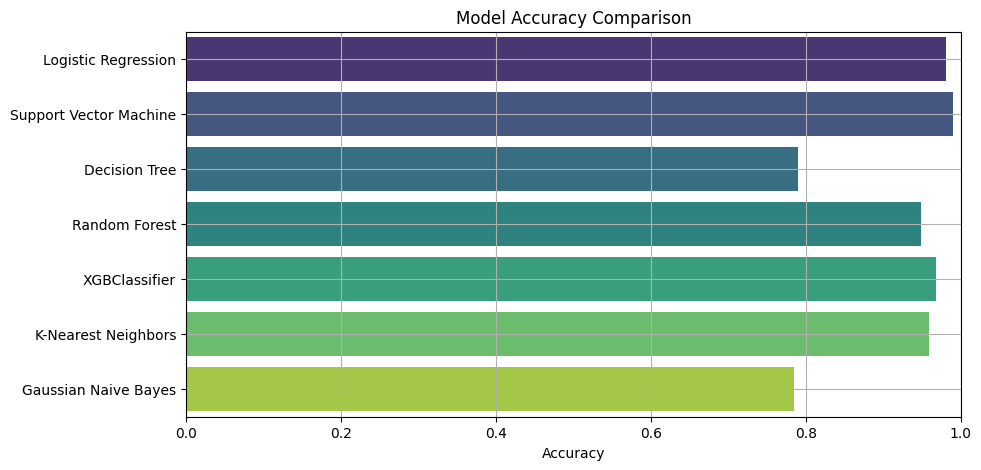

In [39]:
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]

plt.figure(figsize=(10, 5))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)
plt.grid(True)
plt.show()


In [41]:


# CHECK OVERFITTING/UNDERFITTING
# A simple way to check for overfitting/underfitting is to compare training accuracy with testing accuracy.

print("\n--- Checking for Overfitting/Underfitting ---")

for model_name, model in recommended_models.items():
    # Get training predictions
    y_train_pred = model.predict(X_train_reduced)
    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Get testing accuracy from results dictionary
    test_accuracy = results[model_name]["accuracy"]

    print(f"\n{model_name}:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Testing Accuracy:  {test_accuracy:.4f}")

    # Simple check for overfitting/underfitting based on a heuristic
    # These thresholds are just indicative and may need tuning
    difference = train_accuracy - test_accuracy
    if difference > 0.1: # If training accuracy is significantly higher than test accuracy
        print("  Potential Overfitting")
    elif train_accuracy < 0.6 and test_accuracy < 0.6: # If both are low
        print("  Potential Underfitting")
    elif abs(difference) < 0.05 and train_accuracy > 0.8: # If accuracies are close and high
        print("  Good Fit")
    else:
        print("  Acceptable Fit or requires further investigation")




--- Checking for Overfitting/Underfitting ---

Logistic Regression:
  Training Accuracy: 0.9994
  Testing Accuracy:  0.9810
  Good Fit

Support Vector Machine:
  Training Accuracy: 0.9976
  Testing Accuracy:  0.9897
  Good Fit

Decision Tree:
  Training Accuracy: 0.9972
  Testing Accuracy:  0.7900
  Potential Overfitting

Random Forest:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9480
  Acceptable Fit or requires further investigation

XGBClassifier:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9681
  Good Fit

K-Nearest Neighbors:
  Training Accuracy: 1.0000
  Testing Accuracy:  0.9593
  Good Fit

Gaussian Naive Bayes:
  Training Accuracy: 0.8045
  Testing Accuracy:  0.7849
  Good Fit
